# 2110433 - Computer Vision (2024/2)
## Lab 7- Simple Object Recognition
In this lab, we will learn to use useful  handcrafted features to recognize objects in the provied images. This notebook includes both coding and written questions. Please hand in this notebook file with all outputs and your answer

<b>Collaboration is encouraged in this course.</b> You must turn in <b>your own write ups</b> of all problems. If you collaborate with others, you must put the names and ids of the students you worked with in below block.

Collaboration List:
- ...
- ...

In [1]:
import cv2
import math
import numpy as np
import random as rng
from matplotlib import pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

%matplotlib inline

## Maker Based Segmentation

In this section, we will learn how to apply a classic segmentation algorithm named <b>watershed</b>. This algorithm can be used to detect and extract objects in images that are <b>touching and/or overlapping</b> (like RBC in previous Lab!).

Assume that we want to build an application to count coins value from the following image. First of all, we need to segment each coins in to a individual connected component.

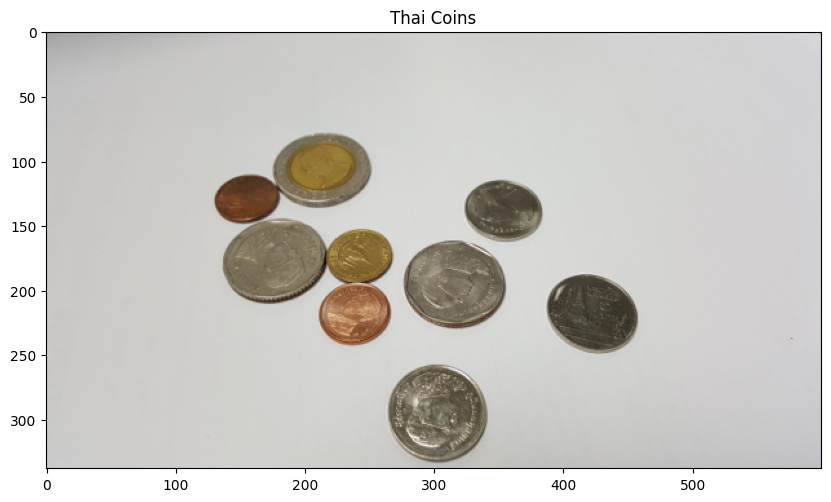

In [2]:
sampleCoinImage = cv2.imread("./assets/Lab7-SampleCoins.jpg")
sampleCoinGray = cv2.cvtColor(sampleCoinImage, cv2.COLOR_BGR2GRAY)
tempImage = cv2.cvtColor(sampleCoinImage, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.title("Thai Coins")
plt.imshow(tempImage)
plt.show()

The following blocks try to use edge information from previous lecture to seperate coins image into individual coin.
Standard Sobel operator is used to extract edge information and only strong edge pixels are kept based on defined threshold. Try to adjust the edge threshold value to seperate each coin from others

In [3]:
def extractSobelEdge(thresholdEdgeVal):
    sampleCoinGrayBlur = cv2.blur(sampleCoinGray, (15, 15))
    sobelX = np.uint8(np.absolute(cv2.Sobel(sampleCoinGrayBlur, cv2.CV_64F, 1, 0, ksize=3)))
    sobelY = np.uint8(np.absolute(cv2.Sobel(sampleCoinGrayBlur, cv2.CV_64F, 0, 1, ksize=3)))
    sobelXY = (sobelX + sobelY) > thresholdEdgeVal
    plt.figure(figsize=(10, 10))
    plt.title("Edge Image")
    plt.imshow(sobelXY, cmap="gray")
    plt.show()


interact(extractSobelEdge, thresholdEdgeVal=widgets.IntSlider(min=0, max=255, step=1, value=1))

interactive(children=(IntSlider(value=1, description='thresholdEdgeVal', max=255), Output()), _dom_classes=('w…

<function __main__.extractSobelEdge(thresholdEdgeVal)>

You can see from the above threshold edge map, even we selects a precise edge threshold, we cannot segment connected coins into individual one. In order to use watershed algorithm, markers muse be place at the corresponded location of the objects in our image. The markers can be either manual define or calculate from various image processing techniques. We will start from using <a href="https://docs.opencv.org/3.4.2/d7/d4d/tutorial_py_thresholding.html">automatic Otsu thesholding</a>.

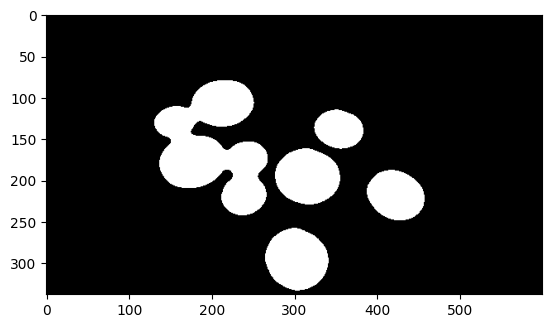

In [4]:
sampleCoinGrayBlur = cv2.medianBlur(sampleCoinGray, 13)
_, thresholdCoinImage = cv2.threshold(sampleCoinGrayBlur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

plt.imshow(thresholdCoinImage, cmap="gray")
plt.show()

This image gray levels can be visualized as follows

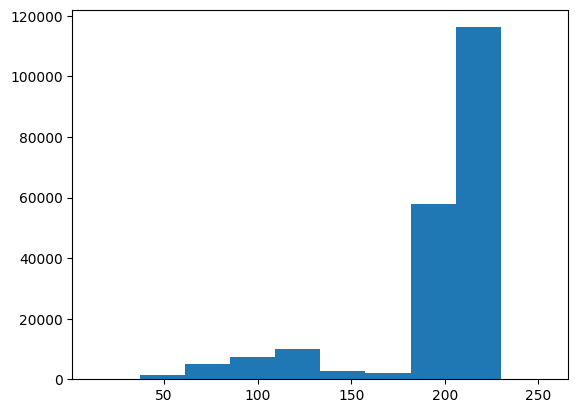

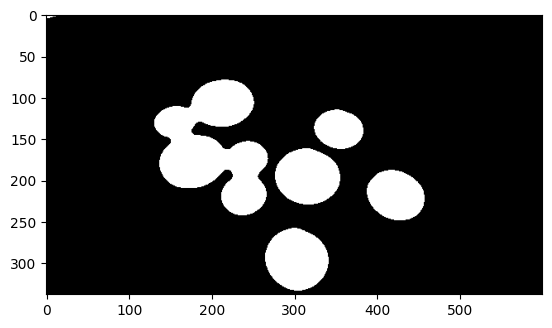

In [5]:
plt.hist(sampleCoinGray.flatten())
plt.show()

plt.imshow(
    sampleCoinGrayBlur < 165, cmap="gray"
)  # we can manually select a proper theshold value to sperate between background and foreground
plt.show()

We then apply <a href="https://docs.opencv.org/3.4.2/d7/d1b/group__imgproc__misc.html#ga8a0b7fdfcb7a13dde018988ba3a43042">distance transform</a> to the thresholding output. Distance transform calculates the approximate or precise distance from every binary image pixel to the nearest zero pixel

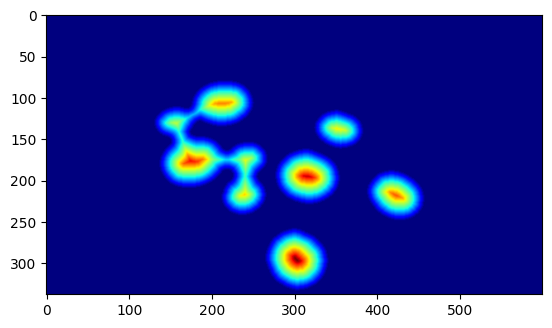

In [6]:
distanceTransformOutput = cv2.distanceTransform(thresholdCoinImage, cv2.DIST_L2, 3)
plt.imshow(distanceTransformOutput, cmap="jet")
plt.show()

Pick only pixel which is greater than 45% of max distance as potential coin markers.

Max Distance: 35.187332


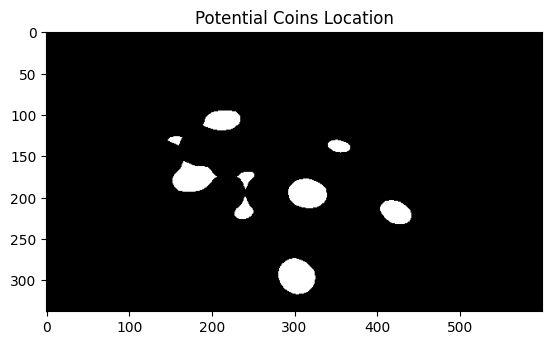

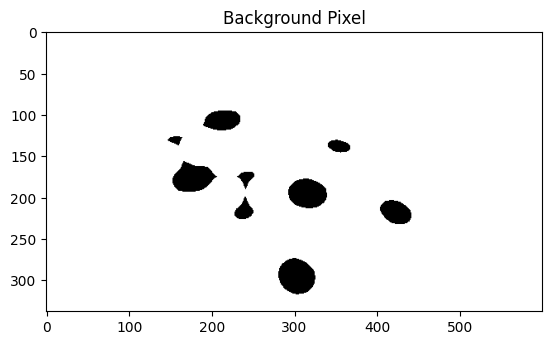

In [7]:
maxDistance = np.max(distanceTransformOutput)
print("Max Distance:", maxDistance)
roughMarkerPixel = np.uint8(distanceTransformOutput > 0.45 * maxDistance)
backgroundMask = np.invert(roughMarkerPixel)
plt.title("Potential Coins Location")
plt.imshow(roughMarkerPixel, cmap="gray")
plt.show()

plt.figure()
plt.title("Background Pixel")
plt.imshow(backgroundMask, cmap="gray")
plt.show()

Labeling each connected component with its unique label number by using <a href="https://docs.opencv.org/3.4.2/d3/dc0/group__imgproc__shape.html#gaedef8c7340499ca391d459122e51bef5">cv2.connectedComponents</a>.

Computes the connected components labeled image of boolean image
image with 4 or 8 way connectivity - returns N, the total number of labels [0, N-1] where 0 represents the background label

Min Label: 0 Max Label: 10


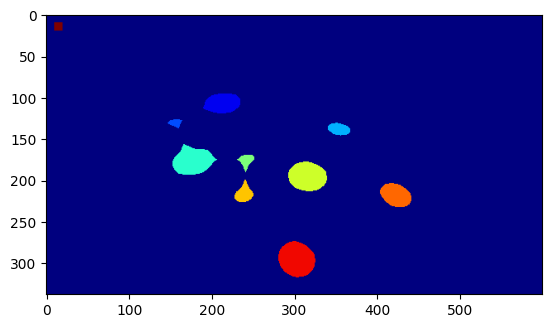

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [8]:
_, seed = cv2.connectedComponents(roughMarkerPixel)
seed[10:20, 10:20] = np.max(seed) + 1
print("Min Label:", np.min(seed), "Max Label:", np.max(seed))
plt.imshow(seed, cmap="jet")
plt.show()
print(seed)

Apply <a href="https://docs.opencv.org/3.4.2/d7/d1b/group__imgproc__misc.html#ga3267243e4d3f95165d55a618c65ac6e1">watershed algorithm</a> using created marker and input coins image. Is there any missing coin? Why? Fix the bug and state your instruction in below block.

Min Label: -1 Max Label: 10


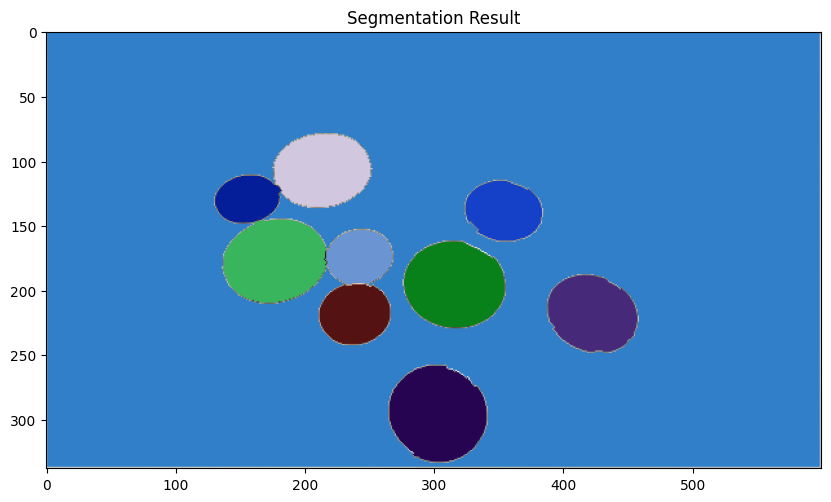

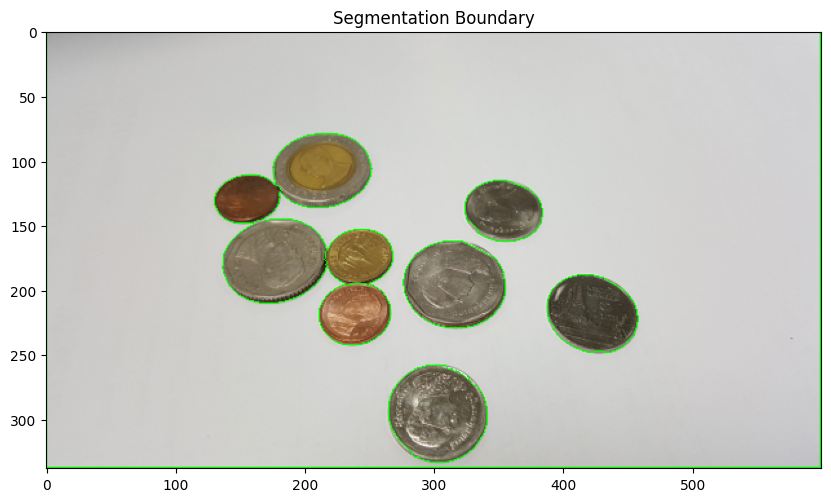

In [9]:
outputImage = sampleCoinImage.copy()
borderImage = sampleCoinImage.copy()
outputMarkers = cv2.watershed(outputImage, seed)  ### Warning seed will get modified here!!
# -1 is border pixel
print("Min Label:", np.min(outputMarkers), "Max Label:", np.max(outputMarkers))

# 1 is background
for outputMarkerIdx in range(1, np.max(outputMarkers + 1)):
    color = (rng.randint(0, 256), rng.randint(0, 256), rng.randint(0, 256))
    outputImage[np.where(outputMarkers == outputMarkerIdx)] = color
outputImage = cv2.cvtColor(outputImage, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.title("Segmentation Result")
plt.imshow(outputImage)
plt.show()

borderImage[np.where(outputMarkers == -1)] = (0, 255, 0)
borderImage = cv2.cvtColor(borderImage, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.title("Segmentation Boundary")
plt.imshow(borderImage)
plt.show()

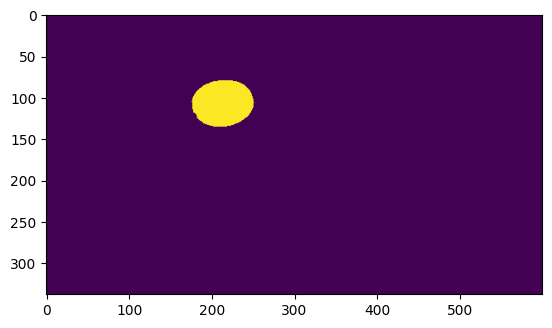

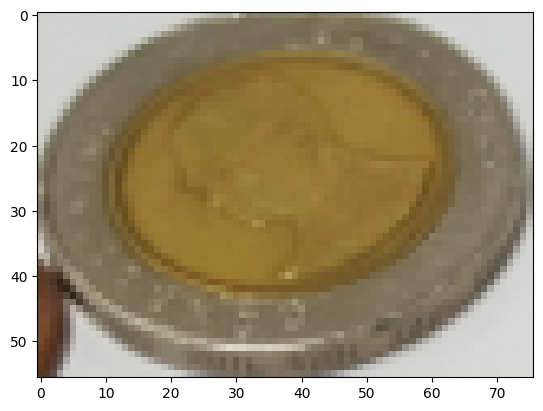

In [10]:
### Crop out individual coin
firstCointMask = outputMarkers == 1
plt.imshow(firstCointMask)
plt.show()

contour, _ = cv2.findContours(firstCointMask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

x, y, w, h = cv2.boundingRect(contour[0])

cropCoinBGR = sampleCoinImage[y : y + h, x : x + w, :]
cropCoinRGB = cv2.cvtColor(cropCoinBGR, cv2.COLOR_BGR2RGB)
plt.imshow(cropCoinRGB)
plt.show()

### Assignment 1 - Coin Counter

From the above section, we can gracefully segment overlpping coins! Your today task is to implement a program to count total coin value from test images provided in assets folder. Please include one of your own test image by using smartphone camera. The images should show robustness of your designed alogorithm such as overlapping coins, tilt camera angle or shadow handling. Don't forget to show your work in step in below block. <br>(Optional) You will get extra points if you can use <b>same parameters</b> for all test images. :)

<b>Remark : </b>
- There are four test images in assets folder. Please hand in the recognition result in image files. 
- You should not count outlier object (key)!!!

<b>Basic Guidance:<b>
1. Segment each coin into individual connected component and find the bounding box which can enclose those connect components by <a href="https://docs.opencv.org/3.4.2/d3/dc0/group__imgproc__shape.html#gacb413ddce8e48ff3ca61ed7cf626a366">cv2.boundingRect</a>
2. For each component, extract <b>useful features</b> (you have to design this by youself).
3. Classify those components into Thai Coin classes.  

<b>Hints:</b>
- How do to discard noise/fill small hole from segmentation mask output? (Previous Lab?)
- Smoothing input image before apply thresholding by using <a href="https://docs.opencv.org/4.5.1/d4/d86/group__imgproc__filter.html#ga8c45db9afe636703801b0b2e440fce37">cv2.blur</a>, <a href="https://docs.opencv.org/4.5.1/d4/d86/group__imgproc__filter.html#ga564869aa33e58769b4469101aac458f9">cv2.medianFilter</a> or <a href="https://docs.opencv.org/4.5.1/d4/d86/group__imgproc__filter.html#ga9fabdce9543bd602445f5db3827e4cc0">cv2.pyrMeanShiftFiltering</a> might be able to improve threshold result.
- From the beginning of this class, you had learned many potential image features, such as edge, color, contour and shape. Use them wisely.
- Internet is your friend. You can search for relavent research papers and use their algorithm, but you must <b>give proper credits</b> by citing them in this notebook. 

In [22]:
### Describe how your algorithm work here (Thai or English). You can provide any visualization if you want.
print("""
1. Segment image
    - Convert BGR -> Gray
    - Add contrast
    - Apply median blur
    - Apply adaptive thresholding
    - Do watershed segmentation
2. Extract coin
    - Iterate each segment
        - Crop only the segment part
        - Classify the coin or not
            - Use circularity to classify (REF: https://www.sciencedirect.com/topics/engineering/circularity)
            - Skip if not a coin
        - If it's coin
        - Classify by color
            - Gold
                - It's 10 baht if the outer circle is silver and inner circle is gold
                - Otherwise, it's 2 baht
            - Copper
                - It's 0.5 baht
            - Silver
                - If it's smaller than 2 baht, it's 1 baht (I gave 10% tolerance, i.e. it can be 10% bigger than 2 baht)
                - Otherwise, it's 5 baht
""".strip())

1. Segment image
    - Convert BGR -> Gray
    - Add contrast
    - Apply median blur
    - Apply adaptive thresholding
    - Do watershed segmentation
2. Extract coin
    - Iterate each segment
        - Crop only the segment part
        - Classify the coin or not
            - Use circularity to classify (REF: https://www.sciencedirect.com/topics/engineering/circularity)
            - Skip if not a coin
        - If it's coin
        - Classify by color
            - Gold
                - It's 10 baht if the outer circle is silver and inner circle is gold
                - Otherwise, it's 2 baht
            - Copper
                - It's 0.5 baht
            - Silver
                - If it's smaller than 2 baht, it's 1 baht (I gave 10% tolerance, i.e. it can be 10% bigger than 2 baht)
                - Otherwise, it's 5 baht


In [12]:
from dataclasses import dataclass, field
from collections import defaultdict


@dataclass
class CounterResult:
    original_image: np.ndarray | None = None
    segmented_image: np.ndarray | None = None
    segment_id_to_value: dict[int, float] = field(default_factory=defaultdict)
    segmented_image_with_value: np.ndarray | None = None
    fifty_satang_count: int = 0
    one_baht_count: int = 0
    two_baht_count: int = 0
    five_baht_count: int = 0
    ten_baht_count: int = 0

    @property
    def total_count(self):
        return (
            + self.fifty_satang_count
            + self.one_baht_count
            + self.two_baht_count
            + self.five_baht_count
            + self.ten_baht_count
        )

    @property
    def total_baht(self):
        return (
            + (self.fifty_satang_count * 0.5)
            + (self.one_baht_count * 1)
            + (self.two_baht_count * 2)
            + (self.five_baht_count * 5)
            + (self.ten_baht_count * 10)
        )
    
    def __str__(self):
        return f"Total Count: {self.total_count}, Total Baht: {self.total_baht}"

In [13]:
coin_material = np.load("coin_material.npz")

coin_material_index_to_label = {
    0: 'silver',
    1: 'gold',
    2: 'copper'
}
coin_material_label_to_index = {
    'silver': 0,
    'gold': 1,
    'copper': 2
}

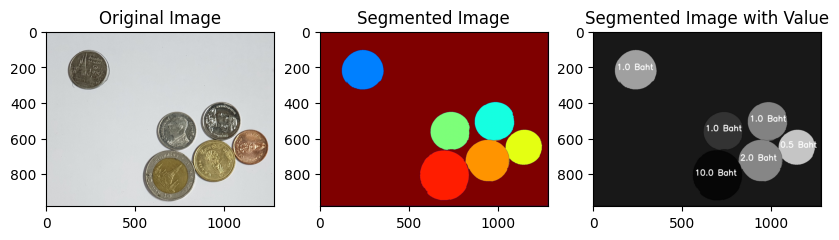

Total Count: 6
Total Baht: 15.5
Fifty Satang Count: 1
One Baht Count: 3
Two Baht Count: 1
Five Baht Count: 0
Ten Baht Count: 1


In [23]:
### FILL HERE ###
from sklearn.neighbors import KNeighborsClassifier
import random
from numpy.fft import fft2, fftshift


class CoinCounter:
    def __init__(self, coin_material_X: np.ndarray, coin_material_y: np.ndarray) -> None:
        # Train the KNN model
        self.coin_material_knn = KNeighborsClassifier(n_neighbors=2, weights="distance")
        self.coin_material_knn.fit(coin_material_X, coin_material_y)

    def count_from_image_path(self, image_path: str) -> CounterResult:
        input_image = cv2.imread(image_path)
        return self.count_from_image(input_image)

    def segment_image_from_image_path(self, image_path: str) -> np.ndarray:
        input_image = cv2.imread(image_path)
        return self.segment_image(input_image)

    def count_from_image(self, input_image: np.ndarray) -> CounterResult:
        counter_result = CounterResult(original_image=input_image.copy())
        segmented_image = self.segment_image(input_image)
        counter_result.segmented_image = segmented_image.copy()
        counter_result.segmented_image_with_value = np.zeros_like(input_image)
        for index in range(1, np.max(segmented_image) + 1):
            counter_result.segmented_image_with_value[segmented_image == index] = random.randint(1, 255)
        counter_result.segmented_image_with_value = counter_result.segmented_image_with_value.astype(np.uint8)
        segmented_amount = np.max(segmented_image) - 1 # Exclude background (last label)
        two_baht_coin_size = None
        segmented_ids = set()
        not_coin_count = 0
        while counter_result.total_count + not_coin_count < segmented_amount:
            for segmented_id in range(1, segmented_amount + 1):
                if segmented_id in segmented_ids:
                    continue
                # Find contour of the interested coin
                coin_mask = segmented_image == segmented_id
                coin_contour, _ = cv2.findContours(coin_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                # Find bounding box of the coin
                x, y, w, h = cv2.boundingRect(coin_contour[0])
                # Crop the coin
                crop_coin_bgr = input_image[y : y + h, x : x + w, :]
                coin_mask = coin_mask[y : y + h, x : x + w]
                # Check if it is the coin
                if not self.is_coin(crop_coin_bgr, coin_mask):
                    segmented_ids.add(segmented_id)
                    not_coin_count += 1
                    continue
                # Get the coin value
                coint_value = self.get_coin_value(crop_coin_bgr, coin_mask, reference_coin_size=two_baht_coin_size)
                if coint_value is not None:
                    # Count the coin
                    match coint_value:
                        case 0.5:
                            counter_result.fifty_satang_count += 1
                            counter_result.segment_id_to_value[segmented_id] = 0.5
                        case 1:
                            counter_result.one_baht_count += 1
                            counter_result.segment_id_to_value[segmented_id] = 1
                        case 2:
                            counter_result.two_baht_count += 1
                            counter_result.segment_id_to_value[segmented_id] = 2
                            two_baht_coin_size = (w, h)
                        case 5:
                            counter_result.five_baht_count += 1
                            counter_result.segment_id_to_value[segmented_id] = 5
                        case 10:
                            counter_result.ten_baht_count += 1
                            counter_result.segment_id_to_value[segmented_id] = 10
                    # Draw the coin value on the segmented image
                    counter_result.segmented_image_with_value = cv2.putText(
                        counter_result.segmented_image_with_value,
                        f"{coint_value } Baht" if coint_value else "Unknown",
                        (x+10, y + h//2),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1.5,
                        (255, 255, 255),
                        3,
                        cv2.LINE_AA,
                    )
                    # Mark the segmented id as processed
                    segmented_ids.add(segmented_id)

        return counter_result

    def segment_image(
        self,
        input_image: np.ndarray,
        median_blur_size: int = 29,
        rough_marker_threshold: float = 0.45,
    ) -> np.ndarray:
        input_image = input_image.copy()
        gray_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
        # Add contrast to the image
        gray_image = cv2.addWeighted(gray_image, 4, gray_image, 0, -700)
        # Threshold the input image
        thresholded_image = self.threshold_image(input_image=gray_image, median_blur_size=median_blur_size)
        # Perform distance transform
        distance_transform = cv2.distanceTransform(thresholded_image, cv2.DIST_L2, 3)
        # Find rough marker pixel
        max_distance = np.max(distance_transform)
        rough_marker_pixel = np.uint8(distance_transform > rough_marker_threshold * max_distance)
        # Find seed and specify background
        _, seed = cv2.connectedComponents(rough_marker_pixel)
        seed[:2, :2] = np.max(seed) + 1
        # Perform watershed
        output_markers = cv2.watershed(input_image, seed)

        return output_markers

    def get_coin_value(self, coin_image: np.ndarray, coin_mask: np.ndarray, reference_coin_size: tuple[int, int] | None = None) -> float | None:
        coin_material = self.classify_coin_material(coin_image, coin_mask)
        # Classify 10 baht coin because it has unique color (mainly gold, but some are silver)
        if coin_material == "gold":
            find_10_bath_image = coin_image.copy()
            find_10_bath_image = cv2.cvtColor(find_10_bath_image, cv2.COLOR_BGR2HSV)
            find_10_bath_image[~coin_mask] = 0.0
            find_10_bath_image = cv2.GaussianBlur(find_10_bath_image, (31, 31), 1000)
            top_color = find_10_bath_image[find_10_bath_image.shape[0]//2, 5]
            mid_color = find_10_bath_image[find_10_bath_image.shape[0]//2, find_10_bath_image.shape[1]//2]
            bot_color = find_10_bath_image[find_10_bath_image.shape[0]//2, find_10_bath_image.shape[1] - 5]
            if abs(int(top_color[1]) - int(bot_color[1])) < 50 and abs(int(top_color[1]) - int(mid_color[1])) > 60:
                # print("10 baht")
                return 10.0
            # The other case is 2 baht coin
            return 2.0
        # If it's copper, it must be 0.5 baht
        if coin_material == "copper":
            return 0.5
        # If it's silver, segment by given size
        if coin_material == "silver":
            if reference_coin_size is None:
                return None
            ref_area = reference_coin_size[0] * reference_coin_size[1]
            this_coin_area = coin_image.shape[0] * coin_image.shape[1]
            if this_coin_area < ref_area * 1.1:
                return 1.0
            return 5.0

    def classify_coin_material(self, coin_image: np.ndarray, coin_mask: np.ndarray) -> str:
        """ Classify the coin material using KNN model """
        # Paint the non-interested coin with the mean of the coin color
        removed_background = coin_image.copy()
        removed_background[~coin_mask] = np.mean(removed_background[coin_mask], axis=0)
        # Use color to classify coin material
        hsv_coin_image = cv2.cvtColor(removed_background, cv2.COLOR_BGR2HSV)
        avg_color = np.mean(hsv_coin_image, axis=(0, 1))
        coin_material_index = self.coin_material_knn.predict([avg_color])[0]
        return coin_material_index_to_label[coin_material_index]

    def threshold_image(self, input_image: np.ndarray, median_blur_size: int) -> np.ndarray:
        """Input image must be gray"""
        input_image = input_image.copy()
        sampleCoinGrayBlur = cv2.medianBlur(input_image, median_blur_size)
        _, thresholdCoinImage = cv2.threshold(sampleCoinGrayBlur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        return thresholdCoinImage

    def is_coin(self, coin_image: np.ndarray, coin_mask: np.ndarray) -> bool:
        """ Check if the given image is a coin """
        # Check if the coin is circle
        coin_mask = coin_mask.astype(np.uint8)
        # Erode the coin mask
        coin_mask = cv2.erode(coin_mask, np.ones((5, 5), np.uint8), iterations=5)
        coin_contour, _ = cv2.findContours(coin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        perimeter = cv2.arcLength(coin_contour[0], True)
        area = cv2.contourArea(coin_contour[0])
        circularity = 4 * math.pi * area / perimeter ** 2
        if circularity < 0.7:
            return False
        else:
            return True

coin_counter = CoinCounter(coin_material_X=coin_material["X"], coin_material_y=coin_material["y"])
counter_result = coin_counter.count_from_image_path("./assets/Lab7-AssignmentC2.jpg")

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(counter_result.original_image, cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 2)
plt.title("Segmented Image")
plt.imshow(counter_result.segmented_image, cmap="jet")
plt.subplot(1, 3, 3)
plt.title("Segmented Image with Value")
plt.imshow(counter_result.segmented_image_with_value)
plt.show()
print("Total Count:", counter_result.total_count)
print("Total Baht:", counter_result.total_baht)
print("Fifty Satang Count:", counter_result.fifty_satang_count)
print("One Baht Count:", counter_result.one_baht_count)
print("Two Baht Count:", counter_result.two_baht_count)
print("Five Baht Count:", counter_result.five_baht_count)
print("Ten Baht Count:", counter_result.ten_baht_count)

Total Count: 7, Total Baht: 20.5
Total Count: 6, Total Baht: 15.5
Total Count: 4, Total Baht: 8.5


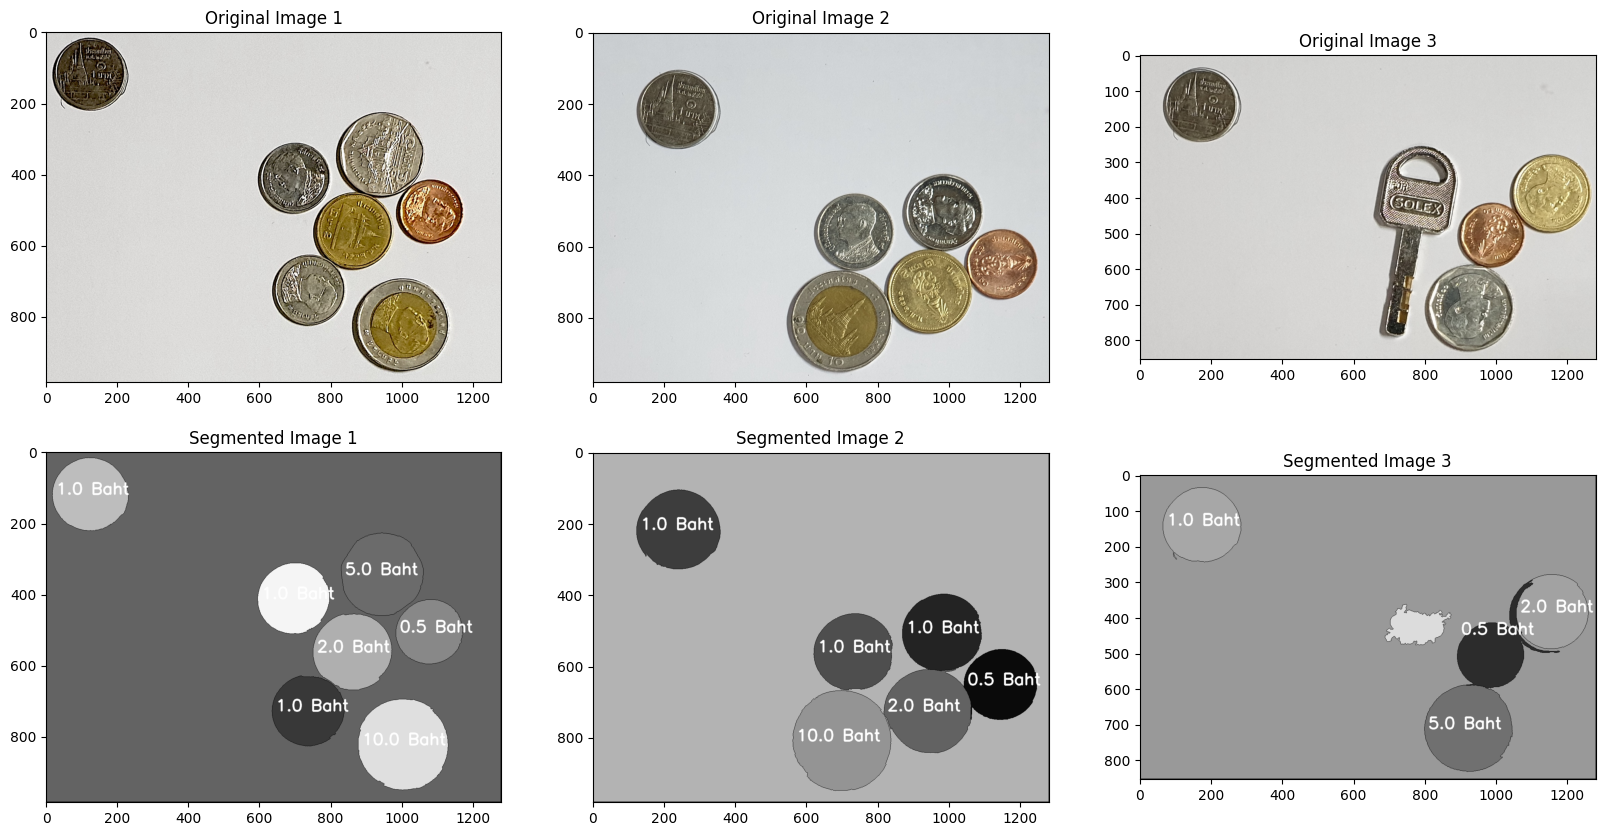

In [24]:
plt.figure(figsize=(20, 10))
for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.title(f"Original Image {i+1}")
    plt.imshow(cv2.cvtColor(cv2.imread(f"./assets/Lab7-AssignmentC{i+1}.jpg"), cv2.COLOR_BGR2RGB))

    counter_result = coin_counter.count_from_image_path(f"./assets/Lab7-AssignmentC{i+1}.jpg")

    plt.subplot(2, 3, i + 4)
    plt.title(f"Segmented Image {i+1}")
    plt.imshow(counter_result.segmented_image_with_value)

    print(coin_counter.count_from_image_path(f"./assets/Lab7-AssignmentC{i+1}.jpg"))
plt.show()